In [1]:
import tensorflow as tf
import os
import numpy as np
import cv2
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D,Conv2DTranspose, concatenate
from keras.layers import LeakyReLU, Dropout, Embedding, Concatenate, BatchNormalization, ReLU, Activation
from keras.utils import plot_model
from keras.initializers import RandomNormal
from PIL import Image
import imageio
from skimage import img_as_ubyte, io
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline 

In [3]:
!unzip '/content/mparticles.zip' -d '/content/'

Archive:  /content/mparticles.zip
replace /content/__MACOSX/._mparticles? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
!pip install split-folders

In [3]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/mparticles", output="/content/mparticles-split", seed=1337, ratio=(.7, .15, .15), group_prefix=None) # default values


Copying files: 3707 files [00:00, 8374.94 files/s]


In [2]:
categories = ['CS','MC','SS']
data_directory = '/content/mparticles-split/train/'

training_data = []

def create_training_data():
    for category in categories:
        path = os.path.join(data_directory, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_array = cv2.resize(img_array, (48,48))
                training_data.append([resized_array, class_num])
            except Exception as e:
                pass

In [3]:
create_training_data()
print(len(training_data))

2593


In [4]:
import random
random.shuffle(training_data)

x_train = []
y_train = []

for features, label in training_data:
    x_train.append(features)
    y_train.append(label)
    
    
x_train = np.array(x_train).reshape(-1, 48, 48, 1)
y_train = np.array(y_train).reshape(-1)

x_train = x_train/255
x_train = x_train.reshape(-1, 48, 48, 1) * 2. - 1.

#y_train = tensorflow.keras.utils.to_categorical(y_train)

2


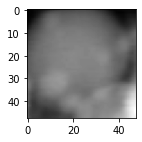

In [5]:
print(y_train[111])
plt.figure(figsize = (8,2))
plt.imshow(x_train[111].reshape(48,48), cmap='gray')
plt.show()

In [7]:
input_shape = (48,48,1)
classes = 3
latent_dim = 100

def build_discriminator():
    init = RandomNormal(mean=0.0, stddev=0.02)
    input_label = Input(shape=(1,))
    emb = Embedding(classes,40)(input_label)
    upsample = Dense(48*48*1)(emb)
    upsample = Reshape((48,48,1))(upsample)
    input_image = Input(shape=(48,48,1))
    concat = Concatenate()([input_image, upsample])

    h = Conv2D(64, kernel_size = (3,3), strides=2, padding='same', kernel_initializer=init)(concat)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.4)(h)

    h = Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer=init)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.4)(h)
    
    h0 = Conv2D(128, kernel_size = (3,3), strides=2, padding='same', kernel_initializer=init)(h)
    h0 = LeakyReLU(alpha=0.2)(h0)
    h0 = Dropout(0.4)(h0)
    
    h1 = Conv2D(128, kernel_size = (3,3), padding='same', kernel_initializer=init)(h0)
    h1 = LeakyReLU(alpha=0.2)(h1)
    h1 = Dropout(0.4)(h1)
    
    h2 = Conv2D(256, kernel_size = (3,3), strides=2, padding='same', kernel_initializer=init)(h1)
    h2 = LeakyReLU(alpha=0.2)(h2)
    h2 = Dropout(0.4)(h2)
    
    flat = Flatten()(h2)
    output = Dense(1, activation='sigmoid')(flat)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    discriminator = Model(inputs=[input_image, input_label], outputs=output)

    discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])    
    return discriminator

In [8]:
def build_generator():
    init = RandomNormal(mean=0.0, stddev=0.02)
    
    input_label = Input(shape=(1,))
    emb = Embedding(classes, 40)(input_label)
    emb = Dense(6*6*1)(emb)
    emb = Reshape((6, 6, 1))(emb)
    input_latent = Input(shape=(latent_dim,)) 
    gen = Dense(256*6*6)(input_latent)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((6,6, 256))(gen)
    merge = Concatenate()([gen, emb])
    
    gen = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_initializer = init)(merge)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer = init)(gen)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    output = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', activation='tanh', kernel_initializer = init)(gen)
    
    model = Model([input_latent, input_label], output)
    return model

In [9]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    generator_latent, generator_label = generator.input
    generator_output = generator.output
    gan_output = discriminator([generator_output, generator_label])

    gan = Model([generator_latent, generator_label], gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    return gan

In [14]:
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)

plot_model(gan)

generator.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 9216)         930816      input_18[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 40)        120         input_17[0][0]                   
___________________________________________________________________________________________

In [15]:
def plot_loss_history(d1, d2, g):
    fig = plt.figure(figsize=(10,6))
    # plt.style.use('seaborn-whitegrid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(d1, 'r', label='d_loss_real')
    plt.plot(d2, 'c', label='d_loss_fake')
    plt.plot(g, 'y', label='g_loss')
    plt.legend(loc='lower left', bbox_to_anchor=(0.82, 0.8), fancybox=True, shadow=True, ncol=1)
    plt.savefig('/content/cgan_logs/cgan_loss_history.png')
    plt.close()
    
def plot_acc_history(a1, a2):
    fig = plt.figure(figsize=(10,6))
    # plt.style.use('seaborn-whitegrid')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(a1, 'r', label='acc_real')     
    plt.plot(a2, 'c', label='acc_fake')
    plt.legend(loc='lower left', bbox_to_anchor=(0.82, 0.04), fancybox=True, shadow=False, ncol=1)
    plt.savefig('/content/cgan_logs/cgan_acc_history.png')
    plt.close()
    
def plot_total_loss(d, g):
    fig = plt.figure(figsize=(10,6))
    # plt.style.use('seaborn-whitegrid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(d, 'r', label='d_loss')
    plt.plot(g, 'y', label='g_loss')
    plt.legend(loc='lower left', bbox_to_anchor=(0.82, 0.8), fancybox=True, shadow=True, ncol=1)
    plt.savefig('/content/cgan_logs/cgan_total_loss.png')
    plt.close()

In [ ]:
plt.style.available

In [ ]:
epochs=10000
batch_size=64

d = list()
d1 = list()
d2 = list()
g  = list() 
a1 = list() 
a2 = list()
da = list()
ga = list()   

def generate_latent_variables(latent_dim, samples, classes=3):
    x = np.random.randn(latent_dim * samples)
    z = x.reshape(samples, latent_dim)
    label = np.random.randint(0, classes, samples)
    return [z, label]
 
def fake_samples(generator, latent_dim, samples):
    z, label = generate_latent_variables(latent_dim, samples)
    images = generator.predict([z, label])
    y = np.zeros((samples, 1))
    return [images, label], y

def real_samples(x_train, samples):
    random_samples = np.random.randint(0, x_train.shape[0], samples)
    x, label = x_train[random_samples], y_train[random_samples]
    y = np.ones((samples, 1))
    return [x, label], y


for i in range(epochs):
    for j in range(58):
                
        [x_real, real_labels], y_real = real_samples(x_train, batch_size//2)
        d_loss_real, d_acc_real = discriminator.train_on_batch([x_real, real_labels], y_real)
            
        [x_fake, fake_labels], y_fake = fake_samples(generator, latent_dim, batch_size//2)
        d_loss_fake, d_acc_fake = discriminator.train_on_batch([x_fake, fake_labels], y_fake)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_acc = 0.5 * np.add(d_acc_real, d_acc_fake)
            
        [z, labels] = generate_latent_variables(latent_dim, batch_size)
        y_gan = np.ones((batch_size, 1))
                    
        g_loss = gan.train_on_batch([z, labels], y_gan)
        
    d.append(d_loss)
    d1.append(d_loss_real)
    d2.append(d_loss_fake)
    g.append(g_loss)
    a1.append(d_acc_real*100)
    a2.append(d_acc_fake*100)
    da.append(d_acc*100)
    
    if (i%200 == 0):
        generator.save(f'/content/cgan_logs/cgan-particles-{i}.h5')
        plot_loss_history(d1, d2, g)
        plot_acc_history(a1, a2)
        plot_total_loss(d, g)
            
    print(f'Epoch: {i+1} --  D_loss_r: {d_loss_real} -- D_loss_f: {d_loss_fake} -- G_loss: {g_loss}')  

In [36]:
x = np.random.randn(latent_dim * 10)
x = x.reshape(10, latent_dim)
labels = np.asarray([x for _ in range(10) for x in range(0,1)])

images  = generator.predict([x, labels])
images = (images+1)/2 * 255

In [37]:
images.shape

(10, 48, 48, 1)

In [ ]:
i=0
for image in images:
    plt.figure(figsize = (10,2))
    i+=1
    # plt.imshow(image.reshape(48,48), cmap='gray')
    # plt.show()
    img_name = f'genrated-cgan-{i}.png'
    imageio.imwrite('/content/imgs/'+img_name, np.array(image))